In [1]:
import os

import geopandas as gpd
import pandas as pd
import numpy as np
import momepy as mm
import networkx as nx

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
from mapclassify import greedy

user = os.environ.get('DB_USERNAME')
pwd = os.environ.get('DB_PASSWORD')
host = os.environ.get('DB_HOSTNAME')
port = os.environ.get('DB_PORT')

url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/geodemo"
engine = create_engine(url)

In [2]:
def pgselect(table, buffer=900, x=338250, y=393000):
    sql = f'''
    SELECT * FROM {table} 
    WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'''
    return gpd.read_postgis(sql, engine, geom_col='geometry')

In [3]:
tables = ('openroads', 'openmaplocal', 'openuprn', )

In [4]:
d = dict()
for t in tables:
    d[t] = pgselect(t)

In [5]:
rds = pgselect('openroads')

In [6]:
bgs = pgselect('openmaplocal')

In [7]:
pn = pgselect('openuprn')

In [8]:
rwy = pgselect('railways')

In [9]:
encs = pgselect('enclosures')

In [10]:
from shapely.geometry import Point
z = Point(338250, 393000)
circle = z.buffer(900)
c = circle.boundary

# slice enclosures with the circle, and keep only contained part

from shapely.ops import split
from shapely.geometry import MultiPolygon

def encircle(polygon):
    return MultiPolygon([p for p in list(split(polygon,c)) if circle.buffer(1).contains(p)])

In [11]:
sliced = encs.geometry.apply(lambda x: encircle(x))
esliced = gpd.GeoDataFrame(geometry=sliced)

In [12]:
these = esliced.loc[~esliced.geometry.apply(lambda x: x.is_empty)]

In [13]:
these['c'] = greedy(these)

<AxesSubplot:>

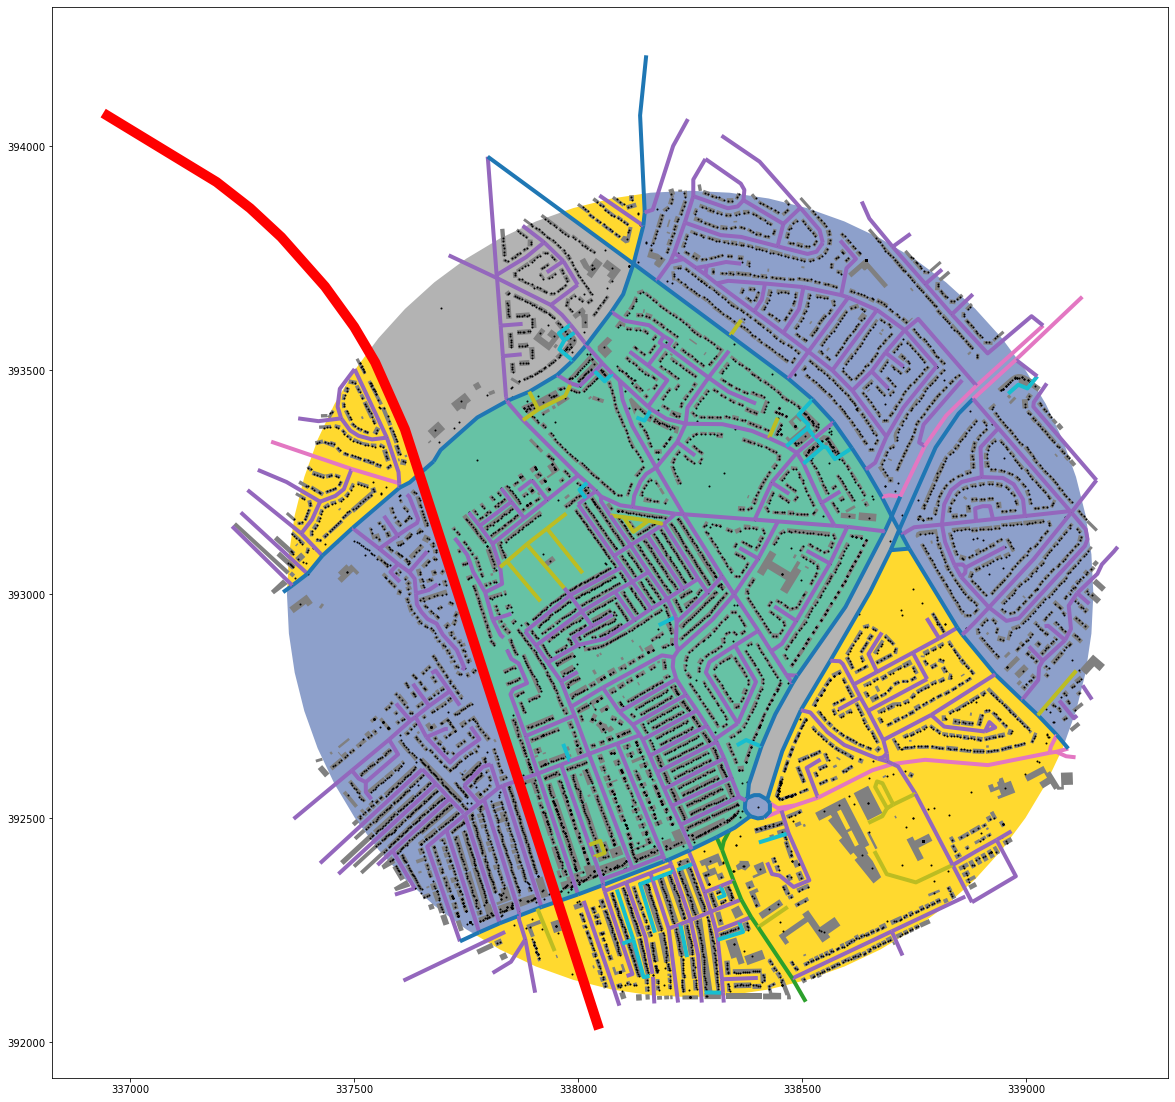

In [14]:
fig, ax = plt.subplots(figsize=(20,20))
these.plot('c', cmap='Set2', ax=ax)
rds.plot('roadFunction', ax=ax, linewidth= 4)
bgs.plot(ax=ax, color='gray')
pn.plot(ax=ax, color='k', markersize=1)
rwy.plot(ax=ax, color='r', linewidth=10)